In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import itertools

https://www.kaggle.com/ouwyukha/copy-of-predict-movie-ratings/code

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,ID,user,movie,rating,timestamp
0,1802700,13239,367,5.0,8.452071e+08
1,1290352,9469,6323,3.5,1.120504e+09
2,2660900,19250,364,4.0,8.402181e+08
3,2563669,18581,6281,2.0,1.063980e+09
4,763295,5798,1569,3.0,1.136088e+09


In [4]:
df.user.nunique()

69878

In [5]:
df.movie.nunique()

10650

<AxesSubplot:>

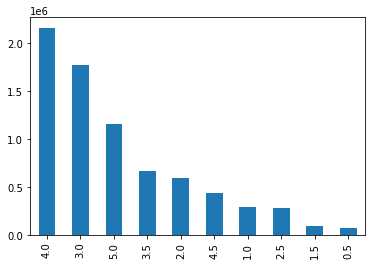

In [6]:
df.rating.value_counts().plot.bar()

### Dataset class

In [7]:
class MovieDataset:
    
    def __init__(self, user, movie, rating):
        self.user = user
        self.movie = movie
        self.rating = rating
        
    def __len__(self):
        return len(self.user)
    
    def __getitem__(self, item):
        
        user = self.user[item]
        movie = self.movie[item]
        rating = self.rating[item]
        
        return {
            'user': torch.tensor(user, dtype=torch.long),
            'movie': torch.tensor(movie, dtype=torch.long),
            'rating': torch.tensor(rating, dtype=torch.float),
        }

In [8]:
encoders={
    'user': sklearn.preprocessing.LabelEncoder(),
    'movie': sklearn.preprocessing.LabelEncoder()
}

df['encoded_user']=encoders['user'].fit_transform(df['user'])
df['encoded_movie']=encoders['movie'].fit_transform(df['movie'])

In [9]:
df_train, df_val = train_test_split(df, test_size=0.2, stratify = df.rating.values)

In [19]:
train_dataset = MovieDataset(df_train.encoded_user.values, df_train.encoded_movie.values, df_train.rating.values)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4096, shuffle=True)

### User - Movie embeddings

In [20]:
emb_size = 64

In [21]:
user_feat = nn.Embedding(df.user.nunique(), emb_size)
movie_feat = nn.Embedding(df.movie.nunique(), emb_size)

### Model definition

In [22]:
class Predictor(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        
        self.lin1 = nn.Linear(2*in_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1, bias=False)
        
    def forward(self, user_feat, movie_feat):
        feats = torch.cat([user_feat, movie_feat], dim=1)
        
        h = F.relu(self.lin1(feats))
        h = self.lin2(h)
        
        return h

### Train loop

In [23]:
def train(model, user_feat, movie_feat, loader, criterion, optim, device):
    model.train()
    
    fin_loss = 0
    
    for data in tqdm.tqdm(loader, total=len(loader)):
        
        optim.zero_grad()
        logits = model(user_feat(data['user'].to(device)), movie_feat(data['movie'].to(device)))
        
        _loss = criterion(logits, data['rating'].to(device).view(-1,1))
        _loss.backward()
        
        optim.step()
        fin_loss += _loss.item()
        
    return fin_loss / len(loader)     

In [24]:
user_feat

Embedding(69878, 64)

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
EPOCHS = 50

model = Predictor(64, 32).to(device)
user_feat = nn.Embedding(df.user.nunique(), emb_size, device=device)
movie_feat = nn.Embedding(df.movie.nunique(), emb_size,device=device)

criterion =nn.MSELoss()
optim = torch.optim.Adam(itertools.chain(
                                         model.parameters(),
                                         user_feat.parameters(),
                                         movie_feat.parameters()),
                         lr=3e-4)

In [29]:
for e in range(EPOCHS):
    epoch_loss = train(model, user_feat, movie_feat, train_loader, criterion, optim, device)
    
    print(f"Epoch {e+1} - MSE: {epoch_loss}")

100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:29<00:00, 16.41it/s]


Epoch 1 - MSE: 2.410343035089278


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:25<00:00, 17.07it/s]


Epoch 2 - MSE: 0.9783793941699604


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:22<00:00, 17.78it/s]


Epoch 3 - MSE: 0.8910525304872429


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:33<00:00, 15.75it/s]


Epoch 4 - MSE: 0.8458451097735773


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:23<00:00, 17.46it/s]


Epoch 5 - MSE: 0.8111038323962241


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:26<00:00, 16.98it/s]


Epoch 6 - MSE: 0.7865278799786096


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:22<00:00, 17.79it/s]


Epoch 7 - MSE: 0.7696913596713095


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:28<00:00, 16.54it/s]


Epoch 8 - MSE: 0.7577716455524692


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:37<00:00, 14.95it/s]


Epoch 9 - MSE: 0.7488911661678613


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:28<00:00, 16.54it/s]


Epoch 10 - MSE: 0.7420687836184844


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:31<00:00, 16.08it/s]


Epoch 11 - MSE: 0.7366067972199501


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:30<00:00, 16.17it/s]


Epoch 12 - MSE: 0.7321263666445892


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:31<00:00, 16.07it/s]


Epoch 13 - MSE: 0.7283092590322267


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:22<00:00, 17.69it/s]


Epoch 14 - MSE: 0.7249841762890995


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:27<00:00, 16.72it/s]


Epoch 15 - MSE: 0.7220717608318394


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:28<00:00, 16.57it/s]


Epoch 16 - MSE: 0.7194303193596849


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:30<00:00, 16.19it/s]


Epoch 17 - MSE: 0.7170193545240591


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:35<00:00, 15.33it/s]


Epoch 18 - MSE: 0.7147615725676761


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:27<00:00, 16.69it/s]


Epoch 19 - MSE: 0.7126376781040491


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:28<00:00, 16.56it/s]


Epoch 20 - MSE: 0.7106283296904059


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:24<00:00, 17.44it/s]


Epoch 21 - MSE: 0.708708034806691


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:25<00:00, 17.05it/s]


Epoch 22 - MSE: 0.7069187702579303


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:25<00:00, 17.17it/s]


Epoch 23 - MSE: 0.7051678873980005


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:28<00:00, 16.60it/s]


Epoch 24 - MSE: 0.703471969256222


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:22<00:00, 17.67it/s]


Epoch 25 - MSE: 0.7018505006926865


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:33<00:00, 15.70it/s]


Epoch 26 - MSE: 0.7002282068997927


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:37<00:00, 15.04it/s]


Epoch 27 - MSE: 0.6986573435747583


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:22<00:00, 17.74it/s]


Epoch 28 - MSE: 0.6971535077274049


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:22<00:00, 17.69it/s]


Epoch 29 - MSE: 0.6956270990925031


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:22<00:00, 17.78it/s]


Epoch 30 - MSE: 0.6941966624797001


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:27<00:00, 16.81it/s]


Epoch 31 - MSE: 0.6927392957967295


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:25<00:00, 17.18it/s]


Epoch 32 - MSE: 0.691325010293173


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:31<00:00, 16.02it/s]


Epoch 33 - MSE: 0.6899464428628264


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:37<00:00, 14.98it/s]


Epoch 34 - MSE: 0.6885663168829049


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:38<00:00, 14.94it/s]


Epoch 35 - MSE: 0.6872084567978114


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:34<00:00, 15.51it/s]


Epoch 36 - MSE: 0.6858517535717414


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:29<00:00, 16.29it/s]


Epoch 37 - MSE: 0.6845235960475414


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:24<00:00, 17.44it/s]


Epoch 38 - MSE: 0.6831828436346998


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:25<00:00, 17.22it/s]


Epoch 39 - MSE: 0.681878433170579


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:27<00:00, 16.65it/s]


Epoch 40 - MSE: 0.6805728693870962


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:29<00:00, 16.36it/s]


Epoch 41 - MSE: 0.6792618594885687


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:22<00:00, 17.77it/s]


Epoch 42 - MSE: 0.6780199543201069


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:33<00:00, 15.65it/s]


Epoch 43 - MSE: 0.6767134403612833


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:28<00:00, 16.52it/s]


Epoch 44 - MSE: 0.6754474531261587


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:24<00:00, 17.44it/s]


Epoch 45 - MSE: 0.6741927046824641


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:23<00:00, 17.52it/s]


Epoch 46 - MSE: 0.6729456537819559


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:37<00:00, 14.98it/s]


Epoch 47 - MSE: 0.67166669108355


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:24<00:00, 17.33it/s]


Epoch 48 - MSE: 0.6704495145599183


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:23<00:00, 17.56it/s]


Epoch 49 - MSE: 0.6692062286386717


100%|██████████████████████████████████████████████████████████████████████████████| 1465/1465 [01:28<00:00, 16.57it/s]

Epoch 50 - MSE: 0.6679645583084419


In [30]:
torch.save(model, 'model.pt')
torch.save(user_feat, 'user_embeddings.pt')
torch.save(movie_feat, 'model_embeddings.pt')